# Recommender Systems

The objective is to **recommend relevant items** for users, based on their **preference**. 
Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.

There are three main category of recommender systems:
+ **Content-Based Filtering**: This method uses attributes of the items to model ***similarity of items*** or user's preferences (based on previousely consumed items). In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various ***candidate items*** are compared with items previously rated by the user and the ***best-matching*** (ranked) items are recommended. 
+ **Collaborative Filtering**: This method ***filters*** items to model interests of a user by collecting preferences or taste information from other users ***collaboration***. The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
+ **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

Dataset for this notebook: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).  

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Data

The data that we will work with is a sample of 12 months logs an article sharing platform. It contains about 73k logged users interactions on more than 3k public articles shared in the platform.
It is composed of two CSV files:  
- **shared_articles.csv**
- **users_interactions.csv**


### Load data

In [2]:
articles_df = pd.read_csv('data/shared_articles.csv')
articles_df.head(5)
# len(articles_df['contentId'].unique())

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


**users_interactions.csv** can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:  
- **VIEW**: The user has opened the article. 
- **LIKE**: The user has liked the article. 
- **COMMENT CREATED**: The user created a comment in the article. 
- **FOLLOW**: The user chose to be notified on any new comment in the article. 
- **BOOKMARK**: The user has bookmarked the article for easy return in the future.

In [4]:
interactions_df = pd.read_csv('data/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


### A bit of EDA

In [5]:
def to_datetime(ts):
    return datetime.fromtimestamp(ts)

def to_datetime_str(ts):
    return to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')

In [6]:
total_count = len(interactions_df)
android_count = len(interactions_df[interactions_df['userAgent'] == 'Android - Native Mobile App'])
ios_count = len(interactions_df[interactions_df['userAgent'] == 'iOS - Native Mobile App'])
print('# of interactions (total): \t%d' % total_count)
print('# of interactions (Android native app): \t%d' % android_count)
print('# of interactions (iOS native app): \t%d' % ios_count)

# of interactions (total): 	72312
# of interactions (Android native app): 	6761
# of interactions (iOS native app): 	103


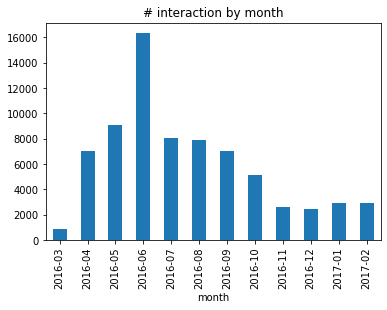

In [7]:
interactions_df['datetime'] = interactions_df['timestamp'].apply(lambda x: to_datetime(x))
interactions_df['month'] = interactions_df['datetime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
interactions_df.groupby('month').size().plot(kind='bar', title='# interaction by month')

In [8]:
interactions_df.groupby('eventType').size().sort_values(ascending=False)

eventType
VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
dtype: int64

In [9]:
print('Distinct articles: \t%d' % len(interactions_df['contentId'].unique()))
print('Distinct users: \t%d' % len(interactions_df['personId'].unique()))
print('Distinct user sessions: \t%d' % len(interactions_df['sessionId'].unique()))

Distinct articles: 	2987
Distinct users: 	1895
Distinct user sessions: 	28740


In [10]:
interactions_df.groupby('personId')['contentId'].size().describe()


count    1895.000000
mean       38.159367
std       104.143355
min         1.000000
25%         3.000000
50%        10.000000
75%        32.000000
max      1885.000000
Name: contentId, dtype: float64

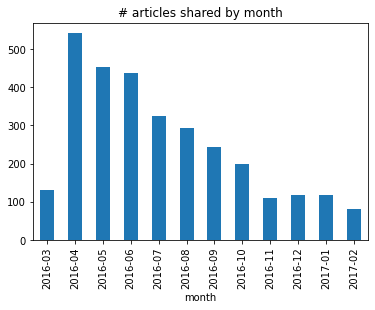

In [11]:
articles_df['datetime'] = articles_df['timestamp'].apply(lambda x: to_datetime(x))
articles_df['month'] = articles_df['datetime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
articles_df[articles_df['eventType'] == 'CONTENT SHARED'].groupby('month').size() \
        .plot(kind='bar', title='# articles shared by month')

In [12]:
articles_df.groupby('eventType').size().sort_values(ascending=False)


eventType
CONTENT SHARED    3047
dtype: int64

In [13]:
print('Distinct articles: \t%d' % len(articles_df['contentId'].unique()))
print('Distinct sharers (users): \t%d' % len(articles_df['authorPersonId'].unique()))

Distinct articles: 	3047
Distinct sharers (users): 	252


In [14]:
articles_df.groupby('contentType').size().sort_values(ascending=False)


contentType
HTML     3027
VIDEO      10
RICH       10
dtype: int64

In [15]:
articles_df.groupby('lang').size().sort_values(ascending=False)


lang
en    2211
pt     829
la       3
ja       2
es       2
dtype: int64

In [16]:
import re
articles_df['urlDomain'] = articles_df['url']\
.apply(lambda x: re.sub(r'^http[s]*:\/\/', '', re.search(r'^http[s]*:\/\/[\w\.]*', x, re.IGNORECASE).group(0)))  #"\w" means "any word character" which usually means alphanumeric (letters, numbers, regardless of case) plus underscore (_)
articles_df[['urlDomain','url']].head()

,urlDomain,url
1,www.nytimes.com,http://www.nytimes.com/2016/03/28/business/dea...
2,cointelegraph.com,http://cointelegraph.com/news/bitcoin-future-w...
3,cloudplatform.googleblog.com,https://cloudplatform.googleblog.com/2016/03/G...
4,bitcoinmagazine.com,https://bitcoinmagazine.com/articles/ibm-wants...
5,www.coindesk.com,http://www.coindesk.com/ieee-blockchain-oxford...


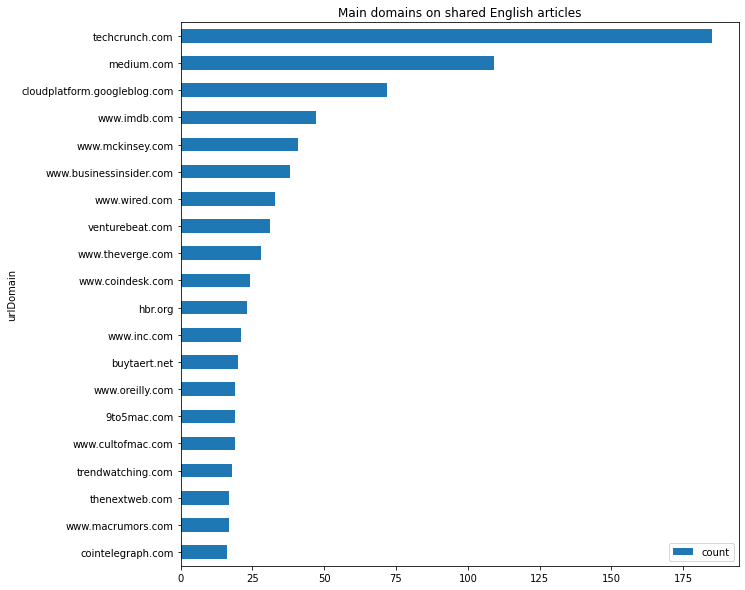

In [58]:
main_domains_df = pd.DataFrame(articles_df[articles_df['lang'] == 'en'].groupby('urlDomain').size().sort_values(ascending=True))[-20:].reset_index()
main_domains_df.columns = ['urlDomain','count']
main_domains_df.plot(kind='barh', x='urlDomain', y='count', figsize=(10,10), title='Main domains on shared English articles')

## Feature Engineering

we associate each interaction with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [18]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [19]:
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,datetime,month,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,2016-06-08 15:10:32,2016-06,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,2016-06-08 15:02:40,2016-06,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,2016-06-08 16:03:10,2016-06,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,2016-06-08 15:24:55,2016-06,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,2016-06-08 14:58:10,2016-06,1.0


Recommender systems have a problem known as **cold-start**, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.
In our case, it makes sense to show articles in the same topic or with a similar content/domain.
For the purpose of this notebook, we only keep users who interacted with at least 5 articles and leave cold-start as an excercise for students.

In [20]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# users: 1895
# users with at least 5 interactions: 1140
# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


To model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [21]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(lambda x: math.log(1+x, 2)).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


## Modeling

In [22]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], # this makes sure to have some of the interaction of a person in training and some in test
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In Recommender Systems, there is a set of metrics commonly used for evaluation. We chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set:
* For each user
    * For each item the user has interacted in test set, called $i$
        * Sample 100 items the user has never interacted with, called A.
        * Make a set of interacted items in test set, called B.
        * Ask the recommender model to produce a ranked list of recommended items, given A union B.
        * Compute the Top-N accuracy metrics for $i$ from the recommendations ranked list (whether $i$ is in the Top-N recommended items or not)
* Aggregate the global Top-N accuracy metrics

Other metrics exist whose score calculation takes into account the position of the relevant item in the ranked list (read e.g. http://fastml.com/evaluating-recommender-systems/)

In [23]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [24]:
def get_items_interacted(person_id, interactions_df):
    # returns the set of interacted items by the given user
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [25]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the interacted items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

### Popularity Model
A common baseline approach is the **Popularity model**. It simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.   
However, this model does not leverage the long-tail items to make a very specific recommendations.

In [26]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [27]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [28]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,34,73,0.273973,0.465753,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,18,69,0.202899,0.260870,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


### Collaborative Filtering
Collaborative Filtering (CF) has two main implementation strategies:

+ Memory-based: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach). This approach is not scalable.

+ Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

#### Singular Value Decomposition (SVD)
Here we a use popular latent factor model named [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition).
An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

You can think of SVD as a:
+ tool for data reduction
+ data-driven generalization of Fourier Transform (FT)
+ basis for PCA or linear regressor (Ax=b) or ...
+ scalable tool to engineer simple and interpretable features
+ Always exist and unique approximation of a matrix

It is a very popular tool and is used in many application (e.g. Google rank algorithm or Amazon and Netflix recommendation systems)

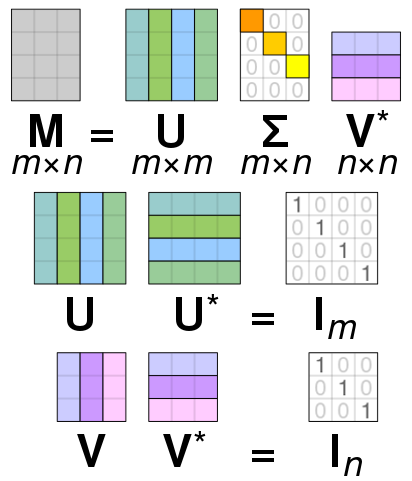

There is a threshold parameter (called factor) for SVD that determines the number of columns of matrix U (and also number of singular values $\sigma_i$ in matrix $\Sigma$) to approximate matrix M when we multiply them back. 

To understand what is the optimal threshold (to have a good trade-off between complexity or size of matrices and the accuracy of the approximation), read this paper: [The Optimal Hard Threshold for Singular Values is 4/sqrt(3)](https://arxiv.org/abs/1305.5870). 

In [29]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [32]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix) # this creates a Scipy Compressed Sparse Row matrix
users_items_pivot_sparse_matrix

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [33]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [34]:
U.shape

(1140, 15)

In [35]:
Vt.shape

(15, 2926)

In [54]:
sigma

array([[26.35998   ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 26.96029367,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 27.73377221,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 28.51766202,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 29.54224668,
         0.        ,  0.        ,  0.        , 

In [36]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [37]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings.shape

(1140, 2926)

In [38]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [39]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.139129,0.137930,0.136531,0.143948,0.136815,0.137339,0.137508,0.143534,0.136428,0.135681,...,0.137351,0.127822,0.137946,0.139653,0.140324,0.136888,0.135787,0.134560,0.135862,0.136246
-9216926795620865886,0.138044,0.137916,0.138698,0.137878,0.137969,0.137990,0.137974,0.138049,0.138217,0.138151,...,0.137962,0.139527,0.138009,0.138117,0.139634,0.138058,0.138222,0.138864,0.138480,0.138323
-9194572880052200111,0.135998,0.137652,0.137283,0.137536,0.140363,0.137807,0.141246,0.136284,0.135301,0.138512,...,0.139257,0.143161,0.139139,0.140077,0.154976,0.140109,0.140654,0.135861,0.139332,0.153114
-9192549002213406534,0.141924,0.137996,0.134663,0.137080,0.139946,0.138574,0.139473,0.144469,0.143333,0.138428,...,0.140233,0.167426,0.138849,0.137037,0.141820,0.139260,0.139513,0.136804,0.140862,0.148793
-9190737901804729417,0.140209,0.137408,0.138708,0.138672,0.137725,0.138218,0.138390,0.138418,0.134883,0.140193,...,0.138373,0.138459,0.138169,0.137990,0.134041,0.137820,0.138100,0.138286,0.138630,0.136178
-9189659052158407108,0.138932,0.138699,0.138117,0.137621,0.138920,0.137766,0.138568,0.138200,0.140572,0.140365,...,0.140725,0.148152,0.137645,0.138165,0.149152,0.138912,0.139595,0.139807,0.140419,0.145698
-9176143510534135851,0.143208,0.138673,0.139514,0.139114,0.137664,0.137447,0.139833,0.140564,0.144698,0.144440,...,0.138367,0.146220,0.136204,0.138087,0.137317,0.137917,0.138546,0.142601,0.141431,0.142154
-9172673334835262304,0.138527,0.138021,0.138274,0.137827,0.137997,0.138037,0.138104,0.138259,0.137633,0.138397,...,0.138588,0.140146,0.138013,0.137839,0.137033,0.137969,0.138337,0.138361,0.138813,0.137538
-9171475473795142532,0.140720,0.137865,0.138061,0.137633,0.138231,0.138089,0.139009,0.137552,0.137143,0.140581,...,0.139046,0.139895,0.138000,0.137958,0.136061,0.138183,0.138817,0.138060,0.139205,0.137198


In [40]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating article that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [41]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,21,46,192,0.109375,0.239583,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


## Content-Based Recommendation?